In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mass_spec_utils

In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

Running standards. First of all, we need to be able to read the new mzML file or csv file. Let's try first with the mzML file.

In [4]:
new_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/Positive/Standards/Std1_1_23Oct18.mzML"
old_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/Positive/Standards/Std1_2_23Oct18.mzML"

Next, we need to extract the standards from inside the new_mzml file.
In order to do this, I quess I will use the method Simon suggested, i.e. choose m/z with highest intensities
(search for method in his code). 

In [5]:
from mass_spec_utils.data_import.mzml import MZMLFile

In [6]:
new_mzml = MZMLFile(new_mzml_file)
old_mzml = MZMLFile(old_mzml_file)

Loaded 1185 scans
Loaded 1192 scans


Next, extract the standards from inside the old_mzml file in the same way as above.

In [7]:
standards_list_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/standards_list.csv"
standards = pd.read_csv(standards_list_file)

In [8]:
sys.path.append("../")
import metab_utils

In [11]:
standards_list = metab_utils.create_std_dict_by_mz(standards, polarity = '+')
with open(osp+'Metabolomics_datasets/standards_list.dict', 'wb') as handle:
    pickle.dump(standards_list, handle)

In [99]:
new_mzml_rts = []
old_mzml_rts = []
ppm = 0.1
for mz in standards_list:
    new_rt = new_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm)[1]
    new_mzml_rts.append(new_rt/60)
    old_rt = old_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm)[1]
    old_mzml_rts.append(old_rt/60)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [138]:
from metab_utils import return_data_with_no_outliers
new_mzml_rts_mod, old_mzml_rts_mod = return_data_with_no_outliers(new_mzml_rts, old_mzml_rts, np.subtract(new_mzml_rts,old_mzml_rts), 1)

print("Choosing the optimal kernel...")
from metab_utils import try_gp_regressions
model, kernel, results = try_gp_regressions(np.array(new_mzml_rts_mod), np.array(old_mzml_rts_mod)-np.array(new_mzml_rts_mod))

Choosing the optimal kernel...
Cross-Predicted Accuracy for RBF : -0.02374298407141029
Mean absolute error for RBF : 0.023185903893535344
Mean squared error for RBF : 0.0008304628192384405
Cross-Predicted Accuracy for MLP : -0.023731728941047914
Mean absolute error for MLP : 0.023185817730390537
Mean squared error for MLP : 0.0008304536890490891


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Cross-Predicted Accuracy for MLP+RBF : 0.0006497385495928265
Mean absolute error for MLP+RBF : 0.023448190464706066
Mean squared error for MLP+RBF : 0.00081067538282918
Cross-Predicted Accuracy for MLP*RBF : 0.19930708724168245
Mean absolute error for MLP*RBF : 0.022213923876467787
Mean squared error for MLP*RBF : 0.0006495240543959892
Cross-Predicted Accuracy for Cosine*RBF : 0.17520470570321045
Mean absolute error for Cosine*RBF : 0.02241888562213524
Mean squared error for Cosine*RBF : 0.000669075965407087
Cross-Predicted Accuracy for Cosine+RBF : -0.023742995522954224
Mean absolute error for Cosine+RBF : 0.023185903221073945
Mean squared error for Cosine+RBF : 0.000830462828527961
Final kernel: MLP*RBF


  mul.                 |                  value  |  constraints  |  priors
  mlp.variance         |    0.00859869660799844  |      +ve      |        
  mlp.weight_variance  |    0.08449223528336045  |      +ve      |        
  mlp.bias_variance    |  3.842095366246017e-06  |      +ve      |        
  rbf.variance         |     0.2163663945107785  |      +ve      |        
  rbf.lengthscale      |      4.817996008776943  |      +ve      |        
Optimization restart 1/10, f = -95.4689809652259
Optimization restart 2/10, f = -95.4689788678081
Optimization restart 3/10, f = -95.46898102327347
Optimization restart 4/10, f = -95.46898021160862
Optimization restart 5/10, f = -95.46898099331186
Optimization restart 6/10, f = -95.46897850025124
Optimization restart 7/10, f = -95.46898114570247
Optimization restart 8/10, f = -95.46897832427607
Optimization restart 9/10, f = -95.46898122079565
Optimization restart 10/10, f = -95.46898130706933


{'dataplot': [<matplotlib.collections.PathCollection at 0x115345700>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x115345ee0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x11d4f38e0>]}

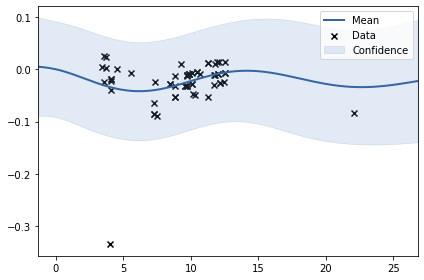

In [122]:
model.optimize_restarts(10)
print(model.parameters[0])
model.plot()

Create method encapsulating the code in this notebook.

In [30]:
def get_gp_for_new_file(new_mzml_file, old_mzml_file, standards_list, mz_ppm = 0.1, zscore = 1):
    from mass_spec_utils.data_import.mzml import MZMLFile
    print("Creating MZMLFile objects...")
    new_mzml = MZMLFile(new_mzml_file)
    old_mzml = MZMLFile(old_mzml_file)
    
    new_mzml_rts = []
    old_mzml_rts = []
   
    for mz in standards_list:
        new_rt = new_mzml.get_max_intensity(mz_min = mz - mz_ppm , mz_max = mz + mz_ppm)[1]
        new_mzml_rts.append(new_rt/60)
        old_rt = old_mzml.get_max_intensity(mz_min = mz - mz_ppm , mz_max = mz + mz_ppm)[1]
        old_mzml_rts.append(old_rt/60)
        
    from metab_utils import return_data_with_no_outliers
    new_mzml_rts_mod, old_mzml_rts_mod = return_data_with_no_outliers(new_mzml_rts, old_mzml_rts, np.subtract(new_mzml_rts,old_mzml_rts), zscore)
    
    print("Choosing the optimal kernel")
    from metab_utils import try_gp_regressions
    model, kernel, results = try_gp_regressions(np.array(new_mzml_rts_mod), np.array(old_mzml_rts_mod)-np.array(new_mzml_rts_mod))
    
    model.optimize_restarts(10)
    print("Kernel hyperparameters:",model.parameters[0])
    model.plot()

Creating MZMLFile objects...
Loaded 1185 scans
Loaded 1192 scans
Choosing the optimal kernel
Cross-Predicted Accuracy for RBF : -0.02374298407141029
Mean absolute error for RBF : 0.023185903893535344
Mean squared error for RBF : 0.0008304628192384405
Cross-Predicted Accuracy for MLP : -0.023731728941047914
Mean absolute error for MLP : 0.023185817730390537
Mean squared error for MLP : 0.0008304536890490891


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Cross-Predicted Accuracy for MLP+RBF : 0.0006497385495928265
Mean absolute error for MLP+RBF : 0.023448190464706066
Mean squared error for MLP+RBF : 0.00081067538282918
Cross-Predicted Accuracy for MLP*RBF : 0.19930708724168245
Mean absolute error for MLP*RBF : 0.022213923876467787
Mean squared error for MLP*RBF : 0.0006495240543959892
Cross-Predicted Accuracy for Cosine*RBF : 0.17520470570321045
Mean absolute error for Cosine*RBF : 0.02241888562213524
Mean squared error for Cosine*RBF : 0.000669075965407087
Cross-Predicted Accuracy for Cosine+RBF : -0.023742995522954224
Mean absolute error for Cosine+RBF : 0.023185903221073945
Mean squared error for Cosine+RBF : 0.000830462828527961
Final kernel: MLP*RBF
Optimization restart 1/10, f = -95.4689809652259
Optimization restart 2/10, f = -95.46898110449027
Optimization restart 3/10, f = -95.46898136122059
Optimization restart 4/10, f = -95.46898113473549
Optimization restart 5/10, f = -95.46897577041662
Optimization restart 6/10, f = -95.4

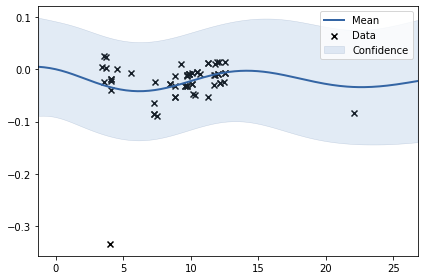

In [142]:
get_gp_for_new_file(new_mzml_file, old_mzml_file, standards_list)

Check fragmentation file

In [5]:
frag_mzml_file = "/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/Metabolomics_datasets/Zika/FRAG/FRAG_POS.mzML"

In [6]:
from mass_spec_utils.data_import.mzml import MZMLFile
frag_mzml = MZMLFile(frag_mzml_file)

Loaded 9657 scans


Create dictionary with the filtered peaks found in the meta-dataset.

In [7]:
annotated_data = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/annotated_data.csv', sep = ',', index_col = 0)

sys.path.append("/Users/anamaria/git/molnet/code/")
import mnet
with open(os.path.join(osp,'pymz/mzmine/HMDBannotated_data.csv'), 'rb') as file:
    annodat = pickle.load(file)   
    
annotated_data['spectra'] = None
for i in annodat.index:
    if i in annotated_data.index:
        annotated_data.at[i, 'spectra'] = annodat.loc[i]['spectra']

In [8]:
filtered_peaks = {}
for _,row in annotated_data.iterrows():
    mz = row['row m/z']
    rt = row['row retention time']
    pval = row['adj p-val']
    cid = row['custom_id']
    mmcn = row['compound_names']
    spec = row['spectra']
    filtered_peaks[mz] = (mmcn, rt*60, '+', None, pval, cid, spec)
    

In [22]:
ppm =0.01
ppm_rt = 3.0
count_rt = 0
count_spec = 0
max_int_peaks = []
specs_names = []
for mz in filtered_peaks:
    
    filtered_peaks_rt =  filtered_peaks[mz][1]
    filtered_peaks_spec = filtered_peaks[mz][6]
    max_int_peaks.append(frag_mzml.get_max_intensity(mz_min = mz - ppm , mz_max = mz +ppm, rt_min_seconds = filtered_peaks_rt - ppm_rt,
                                              rt_max_seconds = filtered_peaks_rt + ppm_rt))
    
    
    if filtered_peaks_spec != None:
        count_spec +=1
        for spec in filtered_peaks_spec.keys():
            specs_names.append(spec)

In [45]:
ints = [i[2] for i in max_int_peaks]
rts = [i[1] for i in max_int_peaks]
mzs = [i[0] for i in max_int_peaks]


In [44]:
print("Lowest intensity: {} \nHighest intensity: {}".format(np.min(ints), np.max(ints)))

Lowest intensity: 2145.0684058222005 
Highest intensity: 338174176.0


Text(0, 0.5, 'Intensity')

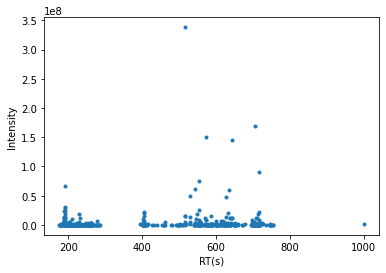

In [48]:
plt.plot(rts, ints, ".")
plt.xlabel("RT(s)")
plt.ylabel("Intensity")

(array([549.,  26.,   9.,   7.,   2.,   0.,   0.,   2.,   1.,   2.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.14506841e+03, 6.76558569e+06, 1.35290263e+07, 2.02924669e+07,
        2.70559075e+07, 3.38193482e+07, 4.05827888e+07, 4.73462294e+07,
        5.41096700e+07, 6.08731106e+07, 6.76365513e+07, 7.43999919e+07,
        8.11634325e+07, 8.79268731e+07, 9.46903137e+07, 1.01453754e+08,
        1.08217195e+08, 1.14980636e+08, 1.21744076e+08, 1.28507517e+08,
        1.35270957e+08, 1.42034398e+08, 1.48797839e+08, 1.55561279e+08,
        1.62324720e+08, 1.69088161e+08, 1.75851601e+08, 1.82615042e+08,
        1.89378482e+08, 1.96141923e+08, 2.02905364e+08, 2.09668804e+08,
        2.16432245e+08, 2.23195685e+08, 2.29959126e+08, 2.36722567e+08,
        2.

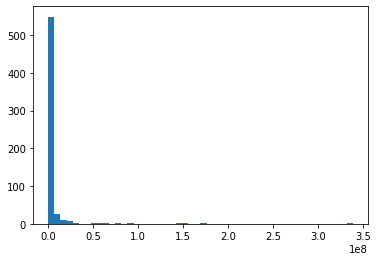

In [63]:
plt.hist(ints, bins = 50)


In [20]:
print("Number of peaks with spectra already attached to them: {}".format(count_spec))

Number of peaks with spectra already attached to them: 215


Text(0.5, 0, 'Datasets')

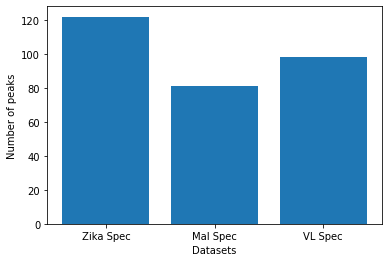

In [30]:
plt.bar(("Zika Spec", "Mal Spec", "VL Spec"), 
        (specs_names.count('gnps2'), specs_names.count('frag_pos_mal'), specs_names.count('frag_pos_vl')))
plt.ylabel("Number of peaks")
plt.xlabel("Datasets")


